# Qiskit Tutorial

**Main page:** https://quantum.ibm.com/

**General documentation:** https://docs.quantum.ibm.com/ 

**Qiskit documentation:** https://docs.quantum.ibm.com/api/qiskit


## Glossary 
**IBM Quantum Platform** is an online platform allowing public and premium access to cloud-based quantum computing services provided by IBM.

**Qiskit** is an open-source software development kit (SDK) for working with quantum computers at the level of extended quantum circuits, operators, and primitives, founded by IBM research. The core component of Qiskit is the Python library qiskit.

In other words, using Qiskit, you can access IBM quantum computers and cloud-based simulators; but it also allows writing code locally and testing it with the simulators on your computer. On the other hand, IBM computers can be accessed through other means, e.g. through APIs of other libraries.


## Before starting



### IBM Quantum Platform
To access IBM Quantum services, you need first to create an IBMid, which can be done on the [IBM Quantum main page](https://quantum.ibm.com/). Please your institutional email.


### Qiskit
To write code with Qiskit, you can:

- Install Qiskit locally, following the instructions here: https://docs.quantum.ibm.com/start/install<br><br>
One library which is not mentioned in instructions but you can find useful is Qiskit Aer (see [Github repo](https://github.com/Qiskit/qiskit-aer)  with installation instructions). While base Qiskit contains simple local simulator, Qiskit Aer has ones with better performance, including GPU support. Besides, it includes various noise models.
<br><br>*Note:* just recently, i.e. 15 February 2024, [Qiskit 1.0](https://www.ibm.com/quantum/blog/qiskit-1-0-release-summary) was released. Therefore, even if you dealt with Qiskit before, please ensure you have **1.x version and not 0.x**. You can refer to [migration guide](https://docs.quantum.ibm.com/api/migration-guides/qiskit-1.0-installation). Most importantly, you must create **new** environment for Qiskit 1.x if you already have one with Qiskit 0.x and **NOT upgrade in-place**.


- Use [Quantum Lab](https://lab.quantum.ibm.com/), a cloud programming environment based on JupyterLab, without installing anything locally. <br>
Note that you need to create an IBMid account first. <br>
More info about Quantum Lab is here: https://docs.quantum.ibm.com/lab

The versions of libraries used in this notebook are:

In [1]:
import qiskit
import qiskit_ibm_runtime
import qiskit_aer

print(qiskit.__version__)
print(qiskit_ibm_runtime.__version__)
print(qiskit_aer.__version__)

1.0.1
0.21.1
0.13.3


## Circuit construction


Let's start with creating a simple circuit from Homework 2, Exercise 1d). It is 2-qubit circuit representing operation $U$ such that:
$$U \left( \left| x \right\rangle \otimes  \left| y \right\rangle \right) =  \left| x \right\rangle \otimes  \left| y \oplus \bar{x} \right\rangle  $$

In [2]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(2)

Here, we initialized 2-qubit circuit. You can pass number of classical bits in the second argument but we don't need that for now. We can even draw it:

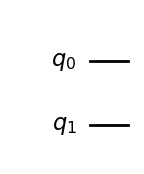

In [3]:
circ.draw('mpl')

Now, we can add gates sequentially:

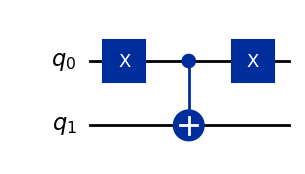

In [4]:
circ.x(0)
circ.cx(0,1)
circ.x(0)

circ.draw('mpl')

You can find more info about available basic gates here: https://docs.quantum.ibm.com/api/qiskit/circuit_library

We can do various stuff here, for example we can create another circuit...

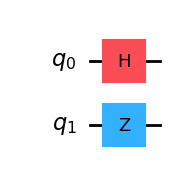

In [5]:
circ2 = QuantumCircuit(2)
circ2.h(0)
circ2.z(1)
circ2.draw('mpl')

and combine the first one with permuted second one (the originals are preserved here).

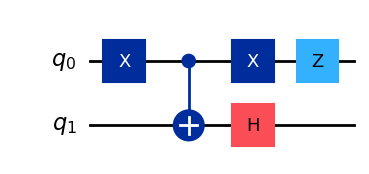

In [6]:
combined = circ.compose(circ2, (1, 0))
combined.draw('mpl')

Some other things about circuit construction you can find here: https://docs.quantum.ibm.com/build/circuit-construction

But let's go back to our first circuit. Suppose we would like to run it. Then, we generally would also like to measure it.

Suppose we want to measure only the bit $q_1$:

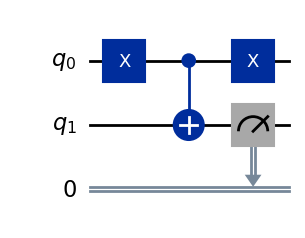

In [7]:
from qiskit.circuit import Clbit
circ_measure_1 = circ.copy()
circ_measure_1.add_bits([Clbit()]) 
circ_measure_1.measure(1, 0)
circ_measure_1.draw('mpl')

Here, we made a copy of circuit because we would like to show another way to add measurements after. <br>
Then, we had to introduce new classical bit because we had no classical ones before and we have to store the result somewhere. Finally, we added a measurement operator.

On the other hand, if we want to measure all the bits, there is a function which allows us to do so:

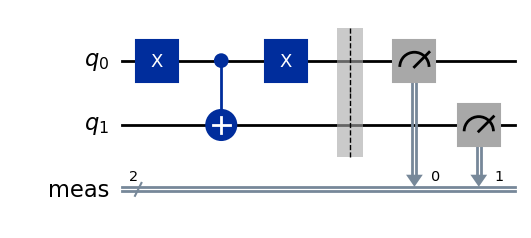

In [8]:
circ_measure_all = circ.copy()
circ_measure_all.measure_all()
circ_measure_all.draw('mpl')

Note that the classical bits were created automatically.

## Running the circuit

As mentioned before, you can either use local simulators or send jobs to cloud services &mdash; real quantum computers and simulators  &mdash; of IBM.

### Local simulators

Using simulators locally helps to test and debug your quantum algorithms quickly. Even cloud simulators require you to wait in a queue before your job runs, let alone actual quantum computers. Besides, local simulation does not require Internet access.


We start with the exact simulator from Qiskit Aer library.

We will run our last circuit measuring both qubits 4000 times. Note that the input state of the circuit is always assumed to be zero! Therefore, result we would expect is $\left| 0 1 \right\rangle$.

In [9]:
from qiskit_aer import AerSimulator

sim_ideal = AerSimulator()  # construct simulator

job_ideal = sim_ideal.run(circ_measure_all, shots=4000)  # launch a job to run the circuit multiple times
res_ideal = job_ideal.result()  # obtain results of a run
counts_ideal = res_ideal.get_counts()  # obtain results of the measumerents

print(counts_ideal)

{'10': 4000}


We got the correct result, but the order of bits is reverse. <br>
This is something you should take into account &mdash; the circuit wires are labeled by default as $q_0 \; q_1 \dots q_{n-1}$, and its state vector by default is written in order $ \left| q_{n-1} \dots q_1 \; q_{0} \right\rangle$ (and not $\left| q_0 \; q_1 \dots q_{n-1}\right\rangle$ as you might have expected).

Now, let's build a circuit which should produce superposition state. For example, let's add Hadamard gate to the first wire:

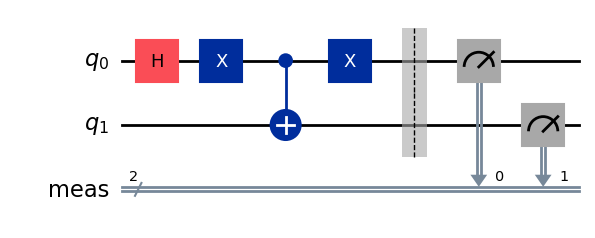

In [10]:
h_gate = QuantumCircuit(2)
h_gate.h(0)
circ_with_h = h_gate.compose(circ_measure_all)
circ_with_h.draw('mpl')

The expected output state before measurement would be $\frac{1}{\sqrt{2}} \left( \left|01 \right\rangle +  \left|10 \right\rangle \right)$. Let's now measure it:

In [11]:
seed = 42  # I put it here for reproducibility, but you may remove it if you wish
res_ideal = sim_ideal.run(circ_with_h, shots=4000, seed_simulator=seed).result()
counts = res_ideal.get_counts()

print(counts)

{'01': 2034, '10': 1966}


Indeed, number of occurences  $\left|01 \right\rangle$ and $\left|10 \right\rangle$ is around the same, although not exactly the same, which is to be expected. We can plot a histogram:

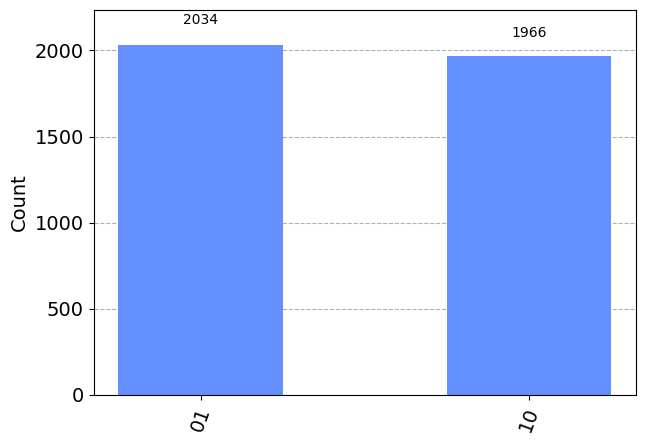

In [12]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

Note: the way to code described here is a legacy way. The modern way is called **primitives**, you can read about them [here](https://docs.quantum.ibm.com/run/primitives).

However, the common practice is not defined yet: particularly, there are versions 1 and 2 of them with difference in usage and default options, but V2 is not yet supported, for example, in Qiskit Aer. If you are curious, you can read below:

- examples of usage in [Qiskit](https://docs.quantum.ibm.com/verify/simulate-with-qiskit-primitives) and [Qiskit Aer](https://docs.quantum.ibm.com/verify/simulate-with-qiskit-aer);
- [migration from `Backend.run()` model to V1 primitives](https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime-examples);
- [migration from V1 to V2](https://docs.quantum.ibm.com/api/migration-guides/v2-primitives).

### Remote instances


Now let's run this circuit remotely. First, we need to get access IBM Quantum systems. <br>
For that, you need access credentials. You can find them by logging in on IBM Quantum Platform and copying the API token from Dashboard: https://quantum.ibm.com/. <br>
Then, you can authenticate as below:

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

TOKEN = <your token>

# One-time access:
service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)

# Save an IBM Quantum account and set it as your default account.
# Please do this only if you trust the device!
QiskitRuntimeService.save_account(channel="ibm_quantum", token=TOKEN, set_as_default=True)
service = QiskitRuntimeService()

If you already saved the credentials on your computer, you can retrieve them without copying the token to the notebook:

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Load saved credentials
service = QiskitRuntimeService()

Now, we can choose what instance to use. To see what is available, you can either check [Compute resources webpage](https://quantum.ibm.com/services/resources) or call a method below:

In [14]:
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>]

This method also has arguments allowing to filter backends depending on your preferences, refer to [documentation](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.QiskitRuntimeService#backends).

We can start with a simulator. Note that even in case of simulator, you might have to wait for some time for your circuit to be launched. <br>
This is the reason we put creation of the job in a separate line from obtaining result &mdash; in case you lose connection to network before obtaining the result, you will still have an object which allows easy access to it; when the job is finished, you can simply call `.result()` again and you will retrieve result, which was already computed.

In [15]:
backend_sim = service.backend('ibmq_qasm_simulator')
job_sim = backend_sim.run(circ_with_h, shots=4000, seed_simulator=seed)
res_sim = job_sim.result()
print(res_sim.get_counts())

{'01': 2034, '10': 1966}


Here, we see the same result as before, down to randomness, as we chose the same simulator model as locally. You can learn about primary differences between them [here](https://docs.quantum.ibm.com/verify/cloud-based-simulators).

By the way, you can still retrieve the job even in case you forgot to create variable for the object or you lost it. You can go to the [Jobs](https://quantum.ibm.com/jobs) page, copy ID of one you are interested in, and do:

In [30]:
job_id = <your job ID>
job_sim = service.job(job_id)
print(job_sim.result().get_counts())

{'01': 2034, '10': 1966}


As we see, the counts are exactly the same!

Now, let's choose true backend. We will use the least busy one, but you can choose any one you want :)

**Warning!** 
Free plan, i.e. [Open Plan](https://docs.quantum.ibm.com/run/instances#open-plan), allows up to:
-  3 jobs  running and/or in the queue at the same time (regardless of whether you submit them to a quantum computer or simulator);
- 10 minutes per month of quantum computing time (simulator usage does not count towards quota). <br>
Resets at 00:00:00 UTC on the first of each calendar month.

Running the part below will use some of the quota; however, it should take several seconds of runtime.

In [16]:
backend_true = service.least_busy(operational=True, simulator=False, min_num_qubits=2)

Now, we would like to send the circuit to a remote instance. However, before this, we have to adapt it to the architecture of the chosen computer: they might have a specific topology and a limited number of implemented basis gates. For example, for our backend, those are:

In [27]:
backend_true.configuration().basis_gates

['ecr', 'id', 'rz', 'sx', 'x']

This process is called transpilation, and you can read about it [here](https://docs.quantum.ibm.com/transpile). The simplest way to perform it is as below:

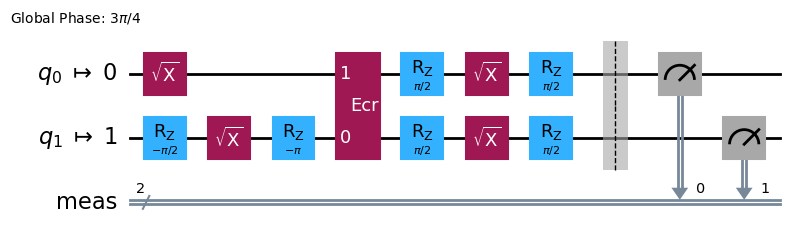

In [22]:
from qiskit import transpile

isa_circ_with_h = transpile(circ_with_h, backend_true)
# without idle_wires option, you will see other 125 qubits on diagram too :)
isa_circ_with_h.draw('mpl', idle_wires=False)  

There are more [advanced and customizable ways](https://docs.quantum.ibm.com/transpile/transpile-with-pass-managers) to do this as well, but for purpose of this course, the function above suffices.

**Warning!** Unfortunately, legacy way does not raise warnings if you forgot to transpile the circuit (the primitives way does). The reason is, before [1 March 2024](https://docs.quantum.ibm.com/announcements/product-updates/2024-02-14-qiskit-runtime-primitives-update), transpilation could be done on the server's side as well; now, however, it is required to be performed on client's side. <br>
Therefore, it is very important to remember to transpile circuit before sending it (or you might wait in the queue for hours just to see failure...).

Finally, we can submit the circuit, which is done the same way as before. Again, you might have to wait for some time. <br>
Note that now we cannot fix the random seed, because the quantum computers are truly random.

In [25]:
job_true = backend_true.run(isa_circ_with_h, shots=4000)
res_true = job_true.result()
print(res_true.get_counts())

{'00': 160, '11': 338, '01': 1820, '10': 1682}


We can see that because of it being a true quantum computer and, consequently, having noise, we see states $\left| 00 \right\rangle$ and $\left| 11 \right\rangle$ that could not exist in perfect computation.

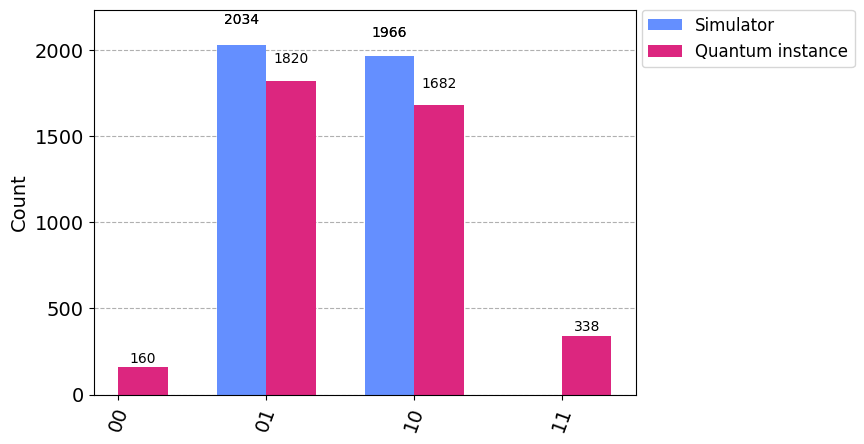

In [26]:
from qiskit.visualization import plot_histogram

counts_true = res_true.get_counts()
plot_histogram([counts, counts_true], legend=['Simulator', 'Quantum instance'])

## Couple of other tricks

### State preparation


Now, what if we wanted to start with some other state? One way is to add gates preparing it manually. Another would be to use a method [.prepare_state(state)](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#prepare_state). For example suppose we want to start with the state $\left| 10 \right\rangle$:

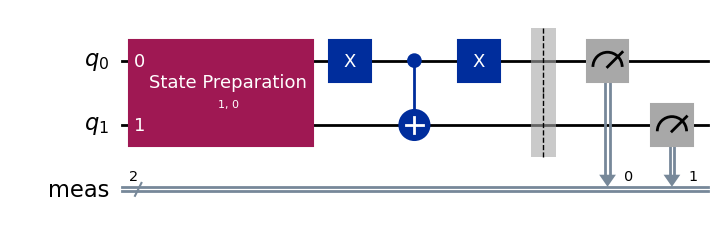

In [31]:
state_10 = QuantumCircuit(2)
state_10.prepare_state('10', state_10.qubits)
state_10_circ = state_10.compose(circ_measure_all)
state_10_circ.draw('mpl')

Note however that this instruction might not be supported from the get-go in the simulator too, so you will still have to transpile circuit:

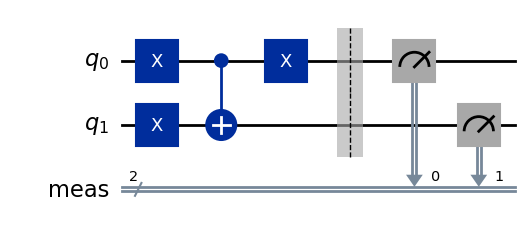

In [37]:
isa_state_10_circ = transpile(state_10_circ, sim_ideal)
isa_state_10_circ.draw('mpl')

As we see, after transpilation,  the instruction of state preparation became just another NOT gate, as it should.

In [41]:
res_state_10 = sim_ideal.run(isa_state_10_circ, shots=4000).result() 
counts_state_10 = res_state_10.get_counts() 
print(counts_state_10)

{'00': 4000}


### Matrix form

We can look at matrix representation of the circuit as well. Note that it should not contain measurement operators:

In [46]:
from qiskit.quantum_info.operators import Operator

op = Operator(circ)
print(op.dim)
print(op.data.real)  # imaginary part is not present here

(4, 4)
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


It seems different from ours in the solution. The reason, again, is reverse order of qubits. We can reverse it back if we wish:

In [48]:
op_rev = op.reverse_qargs()
print(op_rev.data.real)

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Now we see same result as in the solution! <br>

We can also plug a unitary operator in the circuit:

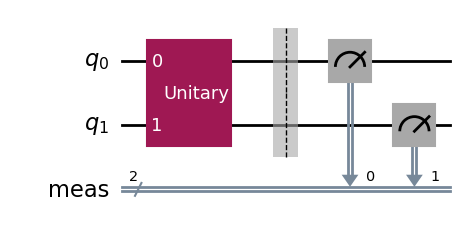

In [55]:
circ_from_op = QuantumCircuit(2)
circ_from_op.unitary(op, range(2))
circ_from_op.measure_all()
circ_from_op.draw('mpl')

In [56]:
res_from_op = sim_ideal.run(circ_from_op, shots=4000).result() 
res_from_op = res_from_op.get_counts() 
print(res_from_op)

{'10': 4000}


## Other useful links
- [Various tutorials and courses](https://learning.quantum.ibm.com/)  on quantum computing with IBM Platform and Qiskit.
- [IBM Quantum Composer](https://quantum.ibm.com/composer/),   a graphical quantum programming tool that lets you drag and drop operations to build quantum circuits and run them on real quantum hardware or simulators. More info [here](https://learning.quantum.ibm.com/tutorial/explore-gates-and-circuits-with-the-quantum-composer).
- [Tutorials on Qiskit Aer](https://qiskit.github.io/qiskit-aer/tutorials/), particularly noise models
- [Qiskit Slack](https://qisk.it/join-slack) community